# Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Library

In [2]:
# import
import pandas as pd
import re
import random
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from peft import LoraConfig, get_peft_model, TaskType
import numpy as np
import seaborn as sns
import textwrap
import ast

# Prepocessing Dataset

In [ ]:
# read dataset
df = pd.read_csv('/content/drive/MyDrive/dataset/2_classes_wo_html.csv')

In [ ]:
# Periksa ringkasan dataset
print("Informasi Dataset:")
df.info()

Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248592 entries, 0 to 248591
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   source_code  248592 non-null  object
 1   vuln_type    248592 non-null  object
 2   vuln_label   248592 non-null  object
 3   tokens       248592 non-null  object
dtypes: object(4)
memory usage: 7.6+ MB


In [ ]:
# Periksa nilai yang hilang
print("Nilai yang Hilang:")
print(df.isna().sum())
df = df.dropna()

Nilai yang Hilang:
source_code    0
vuln_type      0
vuln_label     0
tokens         0
dtype: int64


## Cleaning dataset

In [ ]:
# 5 baris pertama source code sebelum di-cleaning
print("Source code sebelum di-cleaning:")
for i in range(5):
    print(f"\nBaris ke-{i+1}:\n{df['source_code'].iloc[i]}")


Source code sebelum di-cleaning:

Baris ke-1:
<?php
# Init
$db = pg_pconnect("host=postgres-server port=5432 user=postgres password=postgres123 dbname=myDB");


# Sample
$tainted = filter_input(INPUT_GET, "t", FILTER_SANITIZE_EMAIL);
$sanitized = str_replace(["\"", "'", "<", ">"], "", $tainted);
$dataflow = $sanitized;
$context = (("SELECT * FROM users WHERE password ='" . $dataflow) . "';");
$result = pg_query($db, $context);
while(($row = pg_fetch_row($result)))
{
  echo(htmlentities(print_r($row, true)));
}

?>

Baris ke-2:
<?php
# Init

# Sample
$tainted = filter_input(INPUT_GET, "t", FILTER_UNSAFE_RAW);
if(settype($tainted, "string"))
{
  $sanitized = $tainted;
  $dataflow = $sanitized;
  $pre = "<script>alert(\"Hello";
  $post = "\");</script>";
  $context = ($pre . ($dataflow . $post));
  user_error($context);
}

?>

Baris ke-3:
<?php
# Init

# Sample
$tainted = filter_input(INPUT_GET, "t", FILTER_SANITIZE_EMAIL);
$sanitized = str_replace(["\"", "'", "<", ">"], "", $tainted);
$d

In [ ]:
def clean_code(code):
    # Hapus blok komentar /* ... */ dan PHPDoc /** ... */
    code = re.sub(r'/\*[\s\S]*?\*/', '', code)
    # Hapus komentar satu baris //... dan #...
    code = re.sub(r'(^|[^\'"])//.*', r'\1', code)
    code = re.sub(r'(^|[^\'"])#.*', r'\1', code)
    # Hilangkan whitespace awal/akhir tiap baris
    code = '\n'.join(line.strip() for line in code.splitlines())
    # Hilangkan baris kosong
    code = '\n'.join(line for line in code.splitlines() if line.strip())
    return code

df['source_code'] = df['source_code'].apply(clean_code)


In [ ]:
# 5 baris pertama source code sesudah di-cleaning
print("Source code sesudah di-cleaning:")
for i in range(5):
    print(f"\nBaris ke-{i+1}:\n{df['source_code'].iloc[i]}")


Source code sesudah di-cleaning:

Baris ke-1:
<?php
$db = pg_pconnect("host=postgres-server port=5432 user=postgres password=postgres123 dbname=myDB");
$tainted = filter_input(INPUT_GET, "t", FILTER_SANITIZE_EMAIL);
$sanitized = str_replace(["\"", "'", "<", ">"], "", $tainted);
$dataflow = $sanitized;
$context = (("SELECT * FROM users WHERE password ='" . $dataflow) . "';");
$result = pg_query($db, $context);
while(($row = pg_fetch_row($result)))
{
echo(htmlentities(print_r($row, true)));
}
?>

Baris ke-2:
<?php
$tainted = filter_input(INPUT_GET, "t", FILTER_UNSAFE_RAW);
if(settype($tainted, "string"))
{
$sanitized = $tainted;
$dataflow = $sanitized;
$pre = "<script>alert(\"Hello";
$post = "\");</script>";
$context = ($pre . ($dataflow . $post));
user_error($context);
}
?>

Baris ke-3:
<?php
$tainted = filter_input(INPUT_GET, "t", FILTER_SANITIZE_EMAIL);
$sanitized = str_replace(["\"", "'", "<", ">"], "", $tainted);
$dataflow = $sanitized;
$pre = "<script>alert(Hello";
$post = ");</scr

## Cek duplikasi data

In [ ]:
# cek jumlah duplikasi pada atribut source_code
jumlah_duplikat = df.duplicated(subset=['source_code']).sum()

# hapus duplikat dan simpan ke df_unique
df = df.drop_duplicates(subset=['source_code'], keep='first')
df_unique = df.copy()

# cek jumlah baris setelah penghapusan duplikat
baris_sesudah = len(df_unique)

print(f'Jumlah baris duplikat: {jumlah_duplikat}')
print(f'Jumlah baris sesudah: {baris_sesudah}')

Jumlah baris duplikat: 4444
Jumlah baris sesudah: 244148


## Ambil 2000 data

In [ ]:
def stratified_subsample(df, stratify_cols, n_per_group, random_state=42):
    return (
        df.groupby(stratify_cols, group_keys=False)
          .sample(n=n_per_group, random_state=random_state)
          .reset_index(drop=True)
    )

# Menjalankan fungsi subsampling
df_sample = stratified_subsample(df_unique, ['vuln_type', 'vuln_label'], n_per_group=2000)

# Menampilkan informasi hasil subsample
print("Jumlah data setelah stratified subsample:")
print(df_sample.shape)

print("\nDistribusi data per label:")
print(df_sample.groupby(['vuln_label', 'vuln_type']).size())

Jumlah data setelah stratified subsample:
(8000, 4)

Distribusi data per label:
vuln_label  vuln_type
bad         sql          2000
            xss          2000
good        sql          2000
            xss          2000
dtype: int64


In [ ]:
# Ambil hanya kolom source_code dan vuln_label
df_selected = df_sample[['source_code', 'vuln_label']].copy()

# Contoh print 5 baris pertama
print(df_selected.head())

                                         source_code vuln_label
0  <?php\n$servername = "mysql";\n$username = "us...        bad
1  <?php\n$servername = "mysql";\n$username = "us...        bad
2  <?php\n$servername = "mysql";\n$username = "us...        bad
3  <?php\n$servername = "mysql";\n$username = "us...        bad
4  <?php\n$db = new SQLite3("/var/www/db/database...        bad


In [ ]:
# Inisialisasi LabelEncoder untuk masing-masing kolom
label_encoder = LabelEncoder()

# Fit dan transform ke bentuk integer
df_selected['vuln_label_id'] = label_encoder.fit_transform(df_selected['vuln_label'])

# Cetak label unik dan mapping-nya
print(df_selected['vuln_label'].unique())
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

['bad' 'good']
{'bad': np.int64(0), 'good': np.int64(1)}


## Simpan ke file csv baru

In [ ]:
df_selected.to_csv("/content/drive/MyDrive/dataset/dataset3.csv", index=False)
print("CSV berhasil disimpan")

CSV berhasil disimpan


In [ ]:
print(df_selected['source_code'].iloc[3999])

<?php
$pdo = new PDO("mysql:host=mysql;port=3306;dbname=myDB", "username", "password");
$tainted = filter_input_array(INPUT_GET, ["t" => FILTER_SANITIZE_FULL_SPECIAL_CHARS]);
$tainted = $tainted["t"];
$sanitized = crc32($tainted);
$dataflow = $sanitized;
$context = (("SELECT * FROM users WHERE pin =" . $dataflow) . ";");
$results = $pdo->query($context);
foreach ($results as $row){
echo(htmlentities(print_r($row, true)));
}
?>


# Tahapan membuat model

## Load dataset training

In [3]:
# read dataset
df = pd.read_csv('/content/drive/MyDrive/dataset/dataset3.csv')
df

,source_code,vuln_label,vuln_label_id
0,"<?php\n$servername = ""mysql"";\n$username = ""us...",bad,0
1,"<?php\n$servername = ""mysql"";\n$username = ""us...",bad,0
2,"<?php\n$servername = ""mysql"";\n$username = ""us...",bad,0
3,"<?php\n$servername = ""mysql"";\n$username = ""us...",bad,0
4,"<?php\n$db = new SQLite3(""/var/www/db/database...",bad,0
...,...,...,...
7995,"<?php\n$tainted = filter_input(INPUT_GET, ""t"",...",good,1
7996,<?php\n$tainted = filter_input_array(INPUT_GET...,good,1
7997,<?php\n$tainted = filter_input_array(INPUT_GET...,good,1
7998,<?php\n$tainted = filter_input_array(INPUT_GET...,good,1


## Tokenisasi

In [4]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
max_length = 512

# Tokenisasi semua data sekaligus
tokens = tokenizer(
    df['source_code'].tolist(),
    padding='max_length',
    truncation=True,
    max_length=max_length,
    return_tensors='pt'
)

# Tambahkan ke DataFrame
df['input_ids'] = list(tokens['input_ids'].numpy())
df['attention_mask'] = list(tokens['attention_mask'].numpy())
df['token_string'] = df['source_code'].apply(lambda x: tokenizer.tokenize(x))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [5]:
# Tampilkan 5 baris pertama
for i in range(5):
    print("="*100)
    print(f"\n🟩 Baris {i+1}")

    # 1. Kode asli
    print("\n📄 Kode sebelum ditokenisasi:")
    print(df['source_code'].iloc[i])

    # 2. Token string
    print("\n🔤 Kode setelah ditokenisasi (token string):")
    tokens = df['token_string'].iloc[i]
    if isinstance(tokens, str):
        tokens = ast.literal_eval(tokens)
    wrapped_tokens = textwrap.fill(str(tokens), width=80)
    print(wrapped_tokens)

    # 3. input_ids
    print("\n🔢 input_ids:")
    input_ids = df['input_ids'].iloc[i]
    if isinstance(input_ids, str):
        input_ids = ast.literal_eval(input_ids)
    wrapped_ids = textwrap.fill(str(input_ids), width=80)
    print(wrapped_ids)

    # 4. attention_mask
    print("\n🎯 attention_mask:")
    attention = df['attention_mask'].iloc[i]
    if isinstance(attention, str):
        attention = ast.literal_eval(attention)
    wrapped_attention = textwrap.fill(str(attention), width=80)
    print(wrapped_attention)



🟩 Baris 1

📄 Kode sebelum ditokenisasi:
<?php
$servername = "mysql";
$username = "username";
$password = "password";
$dbName = "myDB";
$db = new mysqli($servername, $username, $password, $dbName);
$tainted = apache_request_headers();
$tainted = $tainted["t"];
$sanitized = preg_replace("/'/", "", $tainted);
$dataflow = $sanitized;
$context = (("SELECT * FROM users WHERE pin =" . $dataflow) . ";");
$stmt = mysqli_prepare($db, $context);
mysqli_stmt_execute($stmt);
$results = mysqli_stmt_get_result($stmt);
while(($row = $results->fetch_row()))
{
echo(htmlentities(print_r($row, true)));
}
?>

🔤 Kode setelah ditokenisasi (token string):
['<?', 'php', 'Ċ', '$', 'ser', 'vern', 'ame', 'Ġ=', 'Ġ"', 'mys', 'ql', '";',
'Ċ', '$', 'username', 'Ġ=', 'Ġ"', 'username', '";', 'Ċ', '$', 'password', 'Ġ=',
'Ġ"', 'password', '";', 'Ċ', '$', 'db', 'Name', 'Ġ=', 'Ġ"', 'my', 'DB', '";',
'Ċ', '$', 'db', 'Ġ=', 'Ġnew', 'Ġmy', 'sq', 'li', '($', 'ser', 'vern', 'ame',
',', 'Ġ$', 'username', ',', 'Ġ$', 'password', '

## Split train 70 val 15 test 15

In [6]:
# Split train+val vs test
df_trainval, df_test = train_test_split(
    df,
    test_size=0.15,  # 15% test
    stratify=df["vuln_label_id"],
    random_state=42
)

# Split train vs val (dari sisa trainval)
df_train, df_val = train_test_split(
    df_trainval,
    test_size=0.1765,  # 0.1765 x 85% ≈ 15% total data untuk val
    stratify=df_trainval["vuln_label_id"],
    random_state=42
)

# Cek proporsi
print(f"Jumlah data")
print(f"Data Latih     : {len(df_train)}")
print(f"Data Validasi  : {len(df_val)}")
print(f"Data Uji       : {len(df_test)}\n")

# Tampilkan distribusi label pada masing-masing split
print("Distribusi vuln_label_id")
print("Data Latih:")
print(df_train["vuln_label_id"].value_counts().sort_index())

print("\nData Validasi:")
print(df_val["vuln_label_id"].value_counts().sort_index())

print("\nData Uji:")
print(df_test["vuln_label_id"].value_counts().sort_index())

Jumlah data
Data Latih     : 5599
Data Validasi  : 1201
Data Uji       : 1200

Distribusi vuln_label_id
Data Latih:
vuln_label_id
0    2799
1    2800
Name: count, dtype: int64

Data Validasi:
vuln_label_id
0    601
1    600
Name: count, dtype: int64

Data Uji:
vuln_label_id
0    600
1    600
Name: count, dtype: int64


## DataLoader

In [7]:
class CodeDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.input_ids = df['input_ids'].tolist()
        self.attention_mask = df['attention_mask'].tolist()
        self.vuln_label = df['vuln_label_id'].tolist()

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.attention_mask[idx], dtype=torch.long),
            'vuln_label': torch.tensor(self.vuln_label[idx], dtype=torch.long),
        }

def make_dataloader(df, batch_size=16, shuffle=True):
    dataset = CodeDataset(df)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return loader

train_loader = make_dataloader(df_train, batch_size=16, shuffle=True)
val_loader = make_dataloader(df_val, batch_size=16, shuffle=False)
test_loader = make_dataloader(df_test, batch_size=16, shuffle=False)

In [8]:
# Ambil satu batch dari train_loader
batch = next(iter(train_loader))

# Tampilkan isi batch
print("Isi batch pertama dari train_loader:\n")

print("input_ids:")
print(batch['input_ids'])
print("Shape:", batch['input_ids'].shape)

print("\nattention_mask:")
print(batch['attention_mask'])
print("Shape:", batch['attention_mask'].shape)

print("\nvuln_label:")
print(batch['vuln_label'])
print("Shape:", batch['vuln_label'].shape)


Isi batch pertama dari train_loader:

input_ids:
tensor([[    0, 50254, 28043,  ...,     1,     1,     1],
        [    0, 50254, 28043,  ...,     1,     1,     1],
        [    0, 50254, 28043,  ...,     1,     1,     1],
        ...,
        [    0, 50254, 28043,  ...,     1,     1,     1],
        [    0, 50254, 28043,  ...,     1,     1,     1],
        [    0, 50254, 28043,  ...,     1,     1,     1]])
Shape: torch.Size([16, 512])

attention_mask:
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
Shape: torch.Size([16, 512])

vuln_label:
tensor([0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0])
Shape: torch.Size([16])


## Build Custom Model

In [9]:
class CodebertModel(nn.Module):
    def __init__(self, model_name, num_label):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        self.head_label = nn.Linear(self.encoder.config.hidden_size, num_label)
        self.config = self.encoder.config

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask, **kwargs)
        pooled = outputs.last_hidden_state[:, 0, :]
        logits_label = self.head_label(pooled)
        return logits_label

## Setup LoRA Config & Model

In [10]:
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["query", "key", "value"],  # modul sesuai encoder
    bias="none"
)

model = CodebertModel(
    model_name="microsoft/codebert-base",
    num_label=2
)

# Apply LoRA
model = get_peft_model(model, lora_config)

# Move Model ke Device (GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [11]:
print(model)

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): CodebertModel(
      (encoder): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
          

In [12]:
# Tampilkan jumlah parameter yang dilatih (LoRA)
print("Parameter yang digunakan oleh LoRA:")
model.print_trainable_parameters()

Parameter yang digunakan oleh LoRA:
trainable params: 884,736 || all params: 125,531,906 || trainable%: 0.7048


## Optimizer & Loss

In [13]:
optimizer = optim.AdamW(model.parameters(), lr=2e-4)

## Training

In [14]:
epochs = 3

history = {
    'train_label_loss': [],
    'val_label_loss': [],
    'train_label_accuracy': [],
    'val_label_accuracy': [],
}

for epoch in range(epochs):
    # --- TRAIN ---
    model.train()
    total_loss_label = 0
    correct_label = 0
    total_samples = 0
    batch_count = 0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        label = batch['vuln_label'].to(device)

        optimizer.zero_grad()
        logits_label = model(input_ids=input_ids, attention_mask=attention_mask)
        loss_label = F.cross_entropy(logits_label, label)
        loss_label.backward()
        optimizer.step()

        total_loss_label += loss_label.item()
        pred_label = logits_label.argmax(dim=1)
        correct_label += (pred_label == label).sum().item()
        total_samples += label.size(0)
        batch_count += 1

    avg_train_loss_label = total_loss_label / batch_count
    train_acc_label = correct_label / total_samples

    # --- VALIDATION ---
    model.eval()
    val_loss_label = 0
    val_correct_label = 0
    val_total = 0
    val_batch_count = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            label = batch['vuln_label'].to(device)

            logits_label = model(input_ids=input_ids, attention_mask=attention_mask)
            loss_label = F.cross_entropy(logits_label, label)

            val_loss_label += loss_label.item()
            pred_label = logits_label.argmax(dim=1)
            val_correct_label += (pred_label == label).sum().item()
            val_total += label.size(0)
            val_batch_count += 1

    avg_val_loss_label = val_loss_label / val_batch_count
    val_acc_label = val_correct_label / val_total

    # Simpan history setiap epoch
    history['train_label_loss'].append(avg_train_loss_label)
    history['val_label_loss'].append(avg_val_loss_label)
    history['train_label_accuracy'].append(train_acc_label)
    history['val_label_accuracy'].append(val_acc_label)

    print(f"Epoch {epoch+1} selesai! "
          f"train_label_loss: {avg_train_loss_label:.4f} | val_label_loss: {avg_val_loss_label:.4f} | "
          f"train_label_acc: {train_acc_label:.4f} | val_label_acc: {val_acc_label:.4f}")


Epoch 1 selesai! train_label_loss: 0.5532 | val_label_loss: 0.2351 | train_label_acc: 0.6564 | val_label_acc: 0.9184
Epoch 2 selesai! train_label_loss: 0.1943 | val_label_loss: 0.1753 | train_label_acc: 0.9239 | val_label_acc: 0.9400
Epoch 3 selesai! train_label_loss: 0.1011 | val_label_loss: 0.1109 | train_label_acc: 0.9646 | val_label_acc: 0.9609


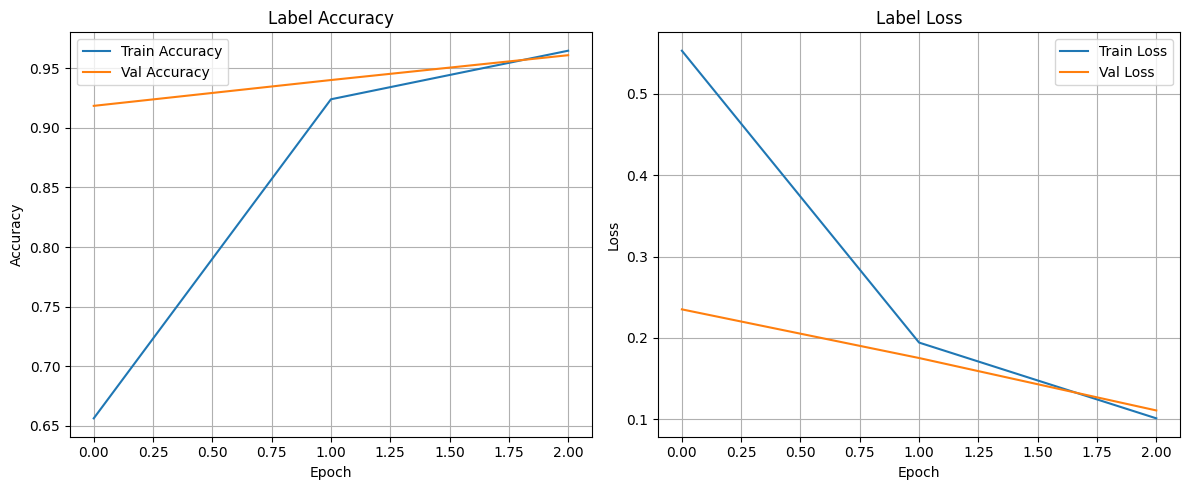

In [15]:
def plot_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot Accuracy
    axes[0].plot(history['train_label_accuracy'], label='Train Accuracy')
    axes[0].plot(history['val_label_accuracy'], label='Val Accuracy')
    axes[0].set_title('Label Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)

    # Plot Loss
    axes[1].plot(history['train_label_loss'], label='Train Loss')
    axes[1].plot(history['val_label_loss'], label='Val Loss')
    axes[1].set_title('Label Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

plot_history(history)

# Evaluasi model

In [16]:
model.eval()
y_true_label = []
y_pred_label = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        label = batch['vuln_label'].cpu().numpy()

        logits_label = model(input_ids=input_ids, attention_mask=attention_mask)
        pred_label = logits_label.argmax(dim=1).cpu().numpy()

        y_true_label.extend(label)
        y_pred_label.extend(pred_label)

# Label: 0 = bad, 1 = good
target_names = ['bad', 'good']
print(classification_report(y_true_label, y_pred_label, target_names=target_names))


              precision    recall  f1-score   support

         bad       0.94      1.00      0.97       600
        good       1.00      0.94      0.97       600

    accuracy                           0.97      1200
   macro avg       0.97      0.97      0.97      1200
weighted avg       0.97      0.97      0.97      1200



## Confusion matrix


Confusion Matrix for vuln_label:


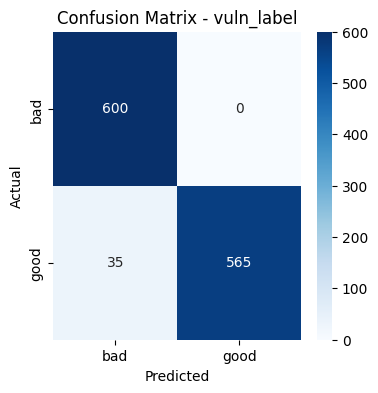

In [17]:
# Nama label manual
class_names = ['bad', 'good']

# Confusion Matrix untuk vuln_label
print("\nConfusion Matrix for vuln_label:")
cm_label = confusion_matrix(y_true_label, y_pred_label)
plt.figure(figsize=(4, 4))
sns.heatmap(
    cm_label,
    annot=True,
    fmt="d",
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title("Confusion Matrix - vuln_label")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Test prediksi mode

In [18]:
def predict_code(model, tokenizer, code_str, max_length=256, device="cpu"):
    # Tokenisasi kode
    tokenized = tokenizer(
        code_str,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )
    input_ids = tokenized['input_ids'].to(device)
    attention_mask = tokenized['attention_mask'].to(device)

    # Forward pass
    model.eval()
    with torch.no_grad():
        logits_label = model(input_ids=input_ids, attention_mask=attention_mask)
        pred_label_id = logits_label.argmax(dim=1).item()

    # Map label ID ke nama label
    class_names = ['Bad', 'Good']
    pred_label_name = class_names[pred_label_id]

    print("Hasil prediksi:")
    print("Vuln label :", pred_label_name)

# Misal mau tes dengan kode SQL Injection:
code_input = """
<?php
$VAR1 = "DATABASE=myDB;HOSTNAME=ibm_db2;PORT=50000;PROTOCOL=TCPIP;UID=db2inst1;PWD=ibm_db2_pw;";
$VAR2 = db2_connect($VAR1, "", "");
$VAR3 = ["safe1", "safe2"];
$VAR4 = filter_input_array(INPUT_GET, ["t" => FILTER_SANITIZE_URL]);
$VAR4 = $VAR4["t"];
if(in_array($VAR4, $VAR3, true))
{
  $VAR5 = $VAR4;
  $VAR6 = $VAR5;
  $VAR7 = (("SELECT * FROM users WHERE password ='" . $VAR6) . "';");
  $VAR8 = db2_prepare($VAR2, $VAR7);
  if($VAR8 == false)
  {
    die(db2_stmt_errormsg());
  }
  $VAR9 = db2_execute($VAR8, []);
  while(($VAR10 = db2_fetch_array($VAR8)))
  {
    echo(htmlentities(print_r($VAR10, true)));
  }
}
?>
"""

# Panggil fungsi prediksi
predict_code(model, tokenizer, code_input, device=device)



Hasil prediksi:
Vuln label : Good


In [19]:
model.eval()
y_true_label = []
y_pred_label = []
misclassified_indices = []

with torch.no_grad():
    for idx, batch in enumerate(test_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        label = batch['vuln_label'].cpu().numpy()

        logits_label = model(input_ids=input_ids, attention_mask=attention_mask)
        pred_label = logits_label.argmax(dim=1).cpu().numpy()

        y_true_label.extend(label)
        y_pred_label.extend(pred_label)

        # simpan index global data yang salah prediksi
        for i in range(len(label)):
            if label[i] != pred_label[i]:
                global_index = idx * test_loader.batch_size + i
                misclassified_indices.append(global_index)

# Laporan akurasi
target_names = ['bad', 'good']
print(classification_report(y_true_label, y_pred_label, target_names=target_names))

# Ambil data yang salah dari DataFrame asli
df_misclassified = df_test.iloc[misclassified_indices].copy()
df_misclassified["pred_label"] = [y_pred_label[i] for i in misclassified_indices]

# Filter khusus PHP
df_php_misclassified = df_misclassified[df_misclassified['source_code'].str.strip().str.startswith("<?php")]

# Simpan hasil
df_php_misclassified.to_csv("php_misclassified.csv", index=False)

label_map_str_to_int = {"bad": 0, "good": 1}
label_map_int_to_str = {0: "bad", 1: "good"}

for row in df_php_misclassified.itertuples(index=False):
    print("="*80)

    # pastikan true_label jadi string
    if isinstance(row.vuln_label, int):
        true_label_str = label_map_int_to_str[row.vuln_label]
    else:
        true_label_str = row.vuln_label

    # pastikan pred_label jadi string
    if isinstance(row.pred_label, int):
        pred_label_str = label_map_int_to_str[row.pred_label]
    else:
        pred_label_str = row.pred_label

    print(f"True Label : {true_label_str}")
    print(f"Pred Label : {pred_label_str}")
    print("Source Code:")
    print(row.source_code)




              precision    recall  f1-score   support

         bad       0.94      1.00      0.97       600
        good       1.00      0.94      0.97       600

    accuracy                           0.97      1200
   macro avg       0.97      0.97      0.97      1200
weighted avg       0.97      0.97      0.97      1200

True Label : good
Pred Label : bad
Source Code:
<?php
$servername = "mysql";
$username = "username";
$password = "password";
$dbName = "myDB";
$db = new mysqli($servername, $username, $password, $dbName);
$tainted = filter_input_array(INPUT_GET, ["t" => FILTER_SANITIZE_URL]);
$tainted = $tainted["t"];
$sanitized = htmlentities($tainted, ENT_COMPAT);
$dataflow = $sanitized;
$context = (("SELECT * FROM users WHERE password =\"" . $dataflow) . "\";");
$stmt = mysqli_prepare($db, $context);
mysqli_stmt_execute($stmt);
$results = mysqli_stmt_get_result($stmt);
while(($row = $results->fetch_row()))
{
echo(htmlentities(print_r($row, true)));
}
?>
True Label : good
Pred La

# Save model

In [21]:
model.save_pretrained("/content/drive/MyDrive/lora_model/")
tokenizer.save_pretrained("/content/drive/MyDrive/lora_model/")

('/content/drive/MyDrive/lora_model/tokenizer_config.json',
 '/content/drive/MyDrive/lora_model/special_tokens_map.json',
 '/content/drive/MyDrive/lora_model/vocab.json',
 '/content/drive/MyDrive/lora_model/merges.txt',
 '/content/drive/MyDrive/lora_model/added_tokens.json',
 '/content/drive/MyDrive/lora_model/tokenizer.json')